In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from pandas import DataFrame, Series
from sklearn.model_selection import train_test_split
from typing import Callable, List, Optional, Union
from sklearn.metrics import accuracy_score
from graphviz import Digraph
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
import math
import random
from IPython.display import Image

In [14]:
!curl -L -o ./diabetes-dataset.zip\
  https://www.kaggle.com/api/v1/datasets/download/iammustafatz/diabetes-prediction-dataset


with zipfile.ZipFile('./diabetes-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  733k  100  733k    0     0   297k      0  0:00:02  0:00:02 --:--:--  672k


In [2]:
def categoricalToNum(dfinput : DataFrame):
    df = dfinput.copy()
    label_encoders = {}
    for col in df.select_dtypes(include=['object', 'bool']).columns:
        # if col != target_feature:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le
    return df

fullDataset = pd.read_csv('diabetes_prediction_dataset.csv')
fullDataset = fullDataset.sample(frac=0.05, random_state=42)



TARGET = 'diabetes'
fullDatasetNorm = fullDataset.copy()
fullDatasetNorm = categoricalToNum(fullDatasetNorm).select_dtypes(include='number')
X_train = fullDatasetNorm.drop(columns=[TARGET])
y_train = fullDatasetNorm[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [3]:
y_train.value_counts()

diabetes
0    3700
1     300
Name: count, dtype: int64

### Структура Решающее Дерево

In [4]:
class DecisionFunction:
    def __init__(self, 
                 feature: str, 
                 threshold: Union[int, float], 
                 decision: Callable[[any], bool]):
        self.feature = feature
        self.threshold = threshold
        self.decision = decision

    def __call__(self, observation: Series) -> any:
        return self.decision(observation)

class Node:
    def __init__(self, categories: List[any]):
        self.categories = categories

class DecisionNode(Node):
    def __init__(self, 
                 categories: List[any], 
                 decision_function: DecisionFunction, 
                 children: Optional[dict] = None):
        super().__init__(categories)
        self.decision_function = decision_function
        self.children = children or {}

    def predict(self, observation: Series) -> any:
        decision = self.decision_function(observation)
        if decision in self.children:
            return self.children[decision].predict(observation)
        raise ValueError(f"Недопустимое значение решения: {decision}")
        
    def set_child(self, 
                  identifier: int, 
                  child_node: 'Node'):
        self.children[identifier] = child_node
    
    def set_end_child(self, 
                      identifier: int, 
                      resultCategory: any):
        
        self.children[identifier] = EndNode(self.categories, resultCategory)

class EndNode(Node):
    def __init__(self, 
                 categories: List[any],
                 resultCategory: any):
        super().__init__(categories)
        self.resultCategory = resultCategory

    def predict(self, observation: Series) -> any:
        return self.resultCategory

### Построение дерева

In [15]:
def fitConstrunct(categories):
    def p(cat, S : DataFrame):
        return len(S[S['TARGET'] == cat]) / len(S)
    def phi(S : DataFrame):
        if len(S) == 0:
            return 1
        return 1 - sum(p(cat, S) ** 2 for cat in categories)

    def usefulnessScore(S : DataFrame, rule):
        S0 = S[rule(S) == 0]
        S1 = S[rule(S) == 1]
        return phi(S) - (len(S0) / len(S)) * phi(S0) - (len(S1) / len(S)) * phi(S1)


    def fit(S : DataFrame, B, depth, args=None): 
        if S['TARGET'].nunique() == 1:
            return EndNode(categories, S['TARGET'].iloc[0])

        if args and 'min_samples_split' in args and len(S) < args['min_samples_split']:
            return EndNode(categories, S['TARGET'].mode()[0])        

        if args and 'max_depth' in args and depth > args['max_depth']:
            return EndNode(categories, S['TARGET'].mode()[0])        


        res_i = max(range(len(B)), key=lambda i: usefulnessScore(S, B[i].decision))
        rule = B[res_i]
        S0 = S[rule(S) == 0]
        S1 = S[rule(S) == 1]
        
        usefull_score = usefulnessScore(S, rule.decision)


        if args and 'min_usefull' in args and usefull_score <= args['min_usefull']:
            return EndNode(categories, S['TARGET'].mode()[0])        


        if S0.empty or S1.empty:
            return EndNode(categories, S['TARGET'].mode()[0])
        
        if args and 'min_samples_leaf' in args :
            if len(S0) < args['min_samples_leaf'] or len(S1) < args['min_samples_leaf']:
                return EndNode(categories, S['TARGET'].mode()[0])
        if args and 'debug' in args and args['debug'] is True:
            print(f"Depth: {depth}")
            print(usefull_score)
            print(f"Rule: {rule.feature} > {rule.threshold}")



        left_child = fit(S0, B, depth + 1, args)
        right_child = fit(S1, B, depth + 1, args)
        
        node = DecisionNode(categories, rule)
        node.set_child(0, left_child)
        node.set_child(1, right_child)
        
        return node
    return fit


def getf(col, trashhold) -> DecisionFunction:
    def f(x : Series):
        return x[col] > trashhold
    return DecisionFunction(col, trashhold, f)

def tree(X : DataFrame, y : Series, args=None):
    S = X.copy()
    if 'TARGET' in S.columns:
        raise ValueError("Column 'TARGET' already exists in the dataframe")
    S['TARGET'] = y

    categories = y.unique().tolist()

    B = []
    for col in S.columns:
        if col != 'TARGET':
            buffer = []
            unique_values = S[col].unique()
            for val in unique_values:
                buffer.append(getf(col, val))
            # если уникальных значений больше sqrt(n), то берем только sqrt(n) случайных
            if len(unique_values) > math.sqrt(len(unique_values)):
                buffer = random.sample(buffer, math.ceil(math.sqrt(len(unique_values))))
            B.extend(buffer)


    return fitConstrunct(categories)(S, B, 0, args)

def stats(someNode):
    y_train_pred = X_train.apply(someNode.predict, axis=1)
    y_test_pred = X_test.apply(someNode.predict, axis=1)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f"Train Accuracy: {train_accuracy}")
    print(f"Test Accuracy: {test_accuracy}")


def draw_tree(node, graph=None, parent=None, edge_label=""):
    if graph is None:
        graph = Digraph()
        graph.attr('node', shape='box')

    node_id = str(id(node))
    if isinstance(node, EndNode):
        graph.node(node_id, label=f"{node.resultCategory}")
    else:
        decision_info = f"Feature: {node.decision_function.feature}\nThreshold: {node.decision_function.threshold}"
        graph.node(node_id, label=f"{decision_info}")

    if parent is not None:
        graph.edge(parent, node_id, label=edge_label)

    if isinstance(node, DecisionNode):
        for edge, child in node.children.items():
            draw_tree(child, graph, node_id, edge_label=str(edge))

    return graph.render("decision_tree", format="png", cleanup=True)

In [20]:
root_node = tree(X_train, y_train, {'max_depth': 4, 'min_samples_leaf': 10, 'min_samples_split': 20, 'min_suefull': 0.01})
zero_node  = EndNode(y_train.unique().tolist(), 0)
# one_node  = EndNode(categories, 1)
stats(root_node)
print("")
stats(zero_node)

Train Accuracy: 0.96975
Test Accuracy: 0.969

Train Accuracy: 0.925
Test Accuracy: 0.918


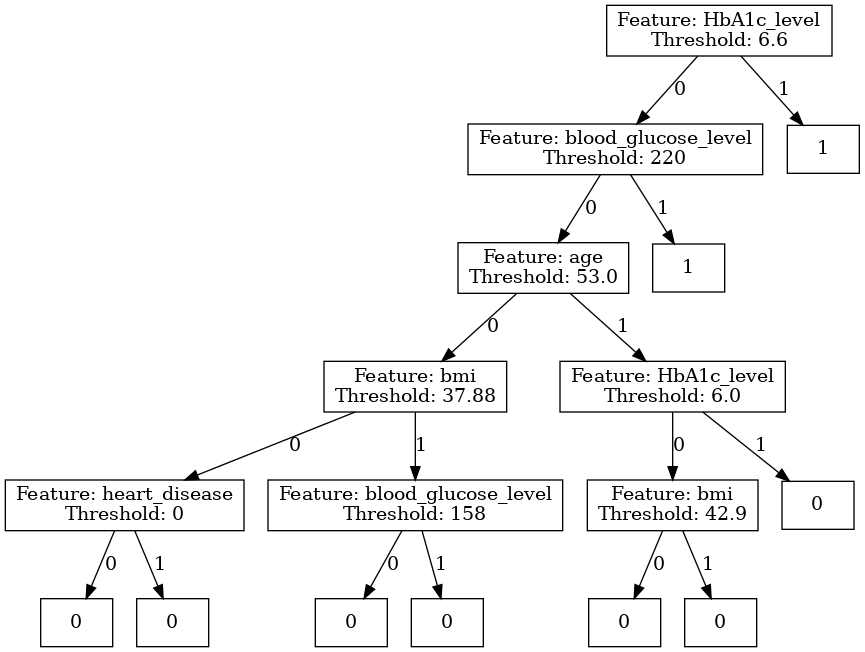

In [21]:
image_path = draw_tree(root_node)
Image(filename=image_path)

## сравнения

### Высота от min_samples_split , accuracy от высоты -- библиотченая

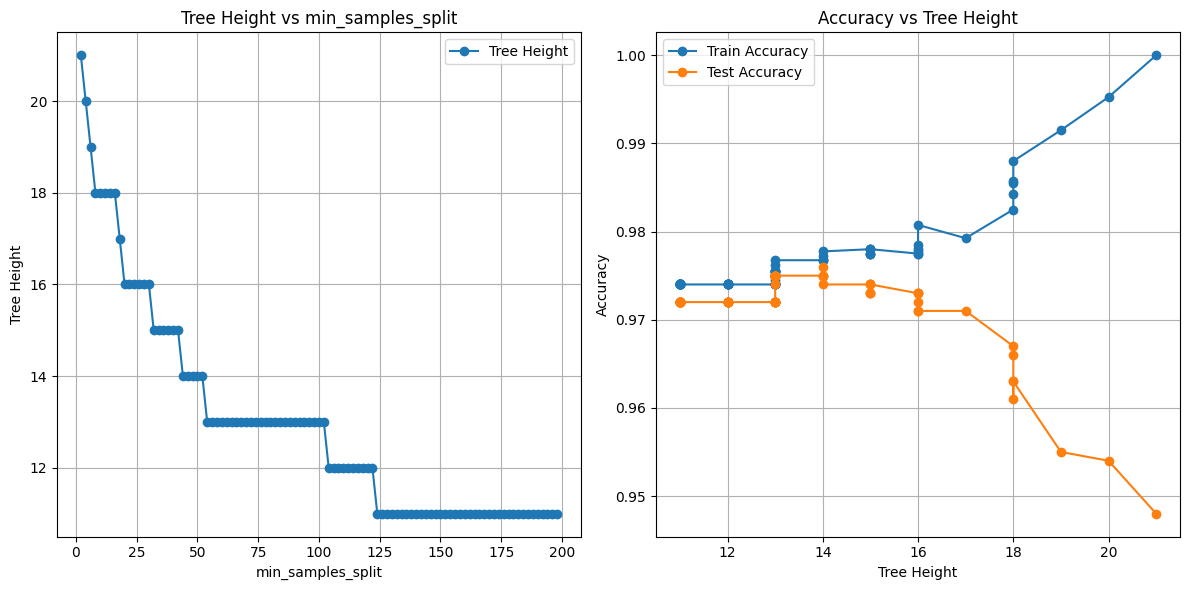

In [22]:
min_samples_split_values = np.arange(2, 200, 2)
tree_heights = []
train_scores = []
test_scores = []

for min_samples_split in min_samples_split_values:
    tree1 = DecisionTreeClassifier(min_samples_split=min_samples_split, random_state=42)
    tree1.fit(X_train, y_train)
    
    tree_heights.append(tree1.tree_.max_depth)
    
    train_scores.append(accuracy_score(y_train, tree1.predict(X_train)))
    test_scores.append(accuracy_score(y_test, tree1.predict(X_test)))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(min_samples_split_values, tree_heights, marker='o', label='Tree Height')
plt.xlabel('min_samples_split')
plt.ylabel('Tree Height')
plt.title('Tree Height vs min_samples_split')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(tree_heights, train_scores, marker='o', label='Train Accuracy')
plt.plot(tree_heights, test_scores, marker='o', label='Test Accuracy')
plt.xlabel('Tree Height')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Tree Height')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


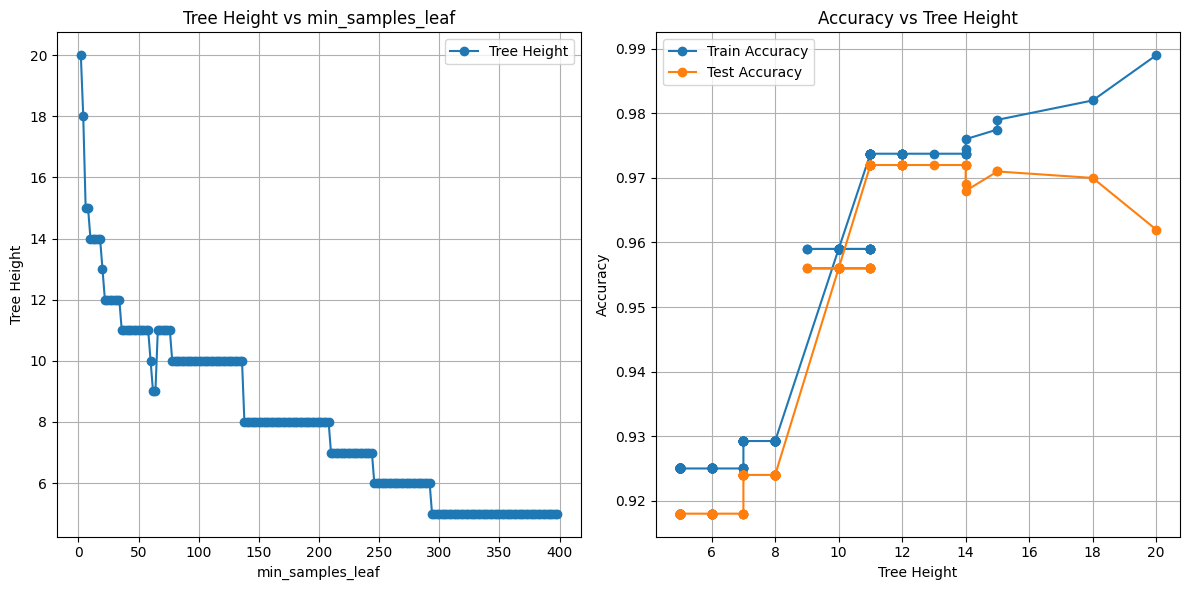

In [35]:
min_samples_leaf_values = np.arange(2, 400, 2)
tree_heights = []
train_scores = []
test_scores = []

for min_samples_split in min_samples_leaf_values:
    tree1 = DecisionTreeClassifier(min_samples_leaf=min_samples_split, random_state=42)
    tree1.fit(X_train, y_train)
    
    tree_heights.append(tree1.tree_.max_depth)
    
    train_scores.append(accuracy_score(y_train, tree1.predict(X_train)))
    test_scores.append(accuracy_score(y_test, tree1.predict(X_test)))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(min_samples_leaf_values, tree_heights, marker='o', label='Tree Height')
plt.xlabel('min_samples_leaf')
plt.ylabel('Tree Height')
plt.title('Tree Height vs min_samples_leaf')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(tree_heights, train_scores, marker='o', label='Train Accuracy')
plt.plot(tree_heights, test_scores, marker='o', label='Test Accuracy')
plt.xlabel('Tree Height')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Tree Height')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


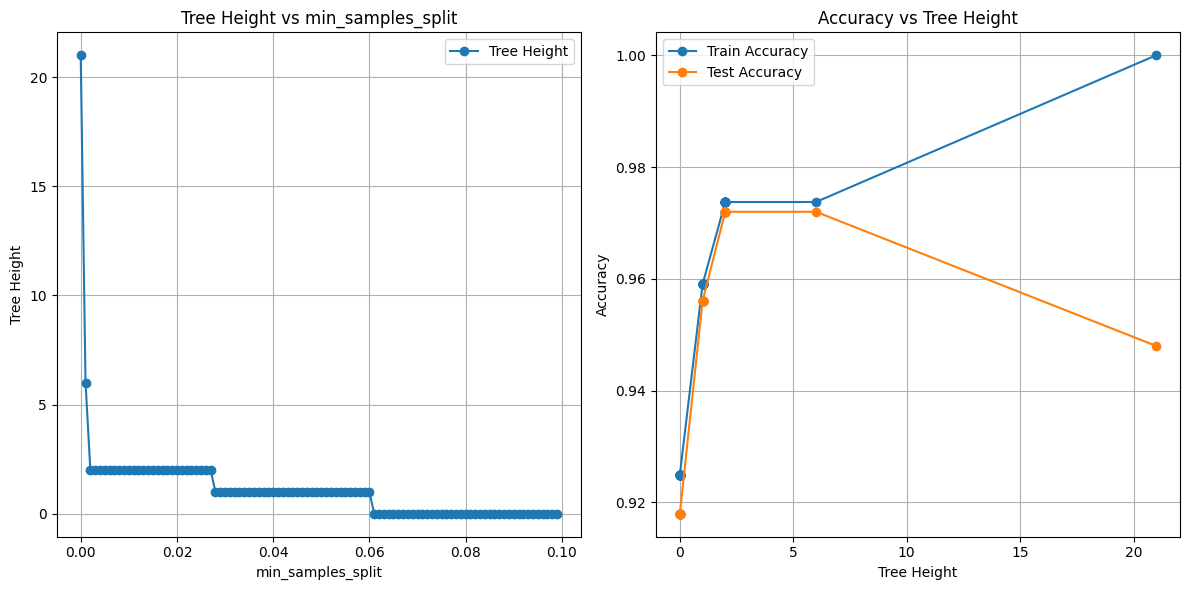

In [42]:
min_impurity_decrease_values = np.arange(0.0, 0.1, 0.001)
tree_heights = []
train_scores = []
test_scores = []

for min_impurity_decrease in min_impurity_decrease_values:
    tree1 = DecisionTreeClassifier(min_impurity_decrease=min_impurity_decrease, random_state=42)
    tree1.fit(X_train, y_train)
    
    tree_heights.append(tree1.tree_.max_depth)
    
    train_scores.append(accuracy_score(y_train, tree1.predict(X_train)))
    test_scores.append(accuracy_score(y_test, tree1.predict(X_test)))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(min_impurity_decrease_values, tree_heights, marker='o', label='Tree Height')
plt.xlabel('min_samples_split')
plt.ylabel('Tree Height')
plt.title('Tree Height vs min_samples_split')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(tree_heights, train_scores, marker='o', label='Train Accuracy')
plt.plot(tree_heights, test_scores, marker='o', label='Test Accuracy')
plt.xlabel('Tree Height')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Tree Height')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


Глубина дерева: 0


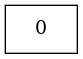

In [69]:
def calculate_tree_depth(node):
    if isinstance(node, EndNode):
        return 0
    max_depth = 0
    for child in node.children.values():
        depth = calculate_tree_depth(child)
        max_depth = max(max_depth, depth)
    return max_depth + 1

root_node = tree(X_train, y_train, {'min_samples_leaf': 100, 'min_samples_split': 100, 'min_usefull': 0.09})
print(f"Глубина дерева: {calculate_tree_depth(root_node)}")
image_path = draw_tree(root_node)
Image(filename=image_path)


## моя реализация

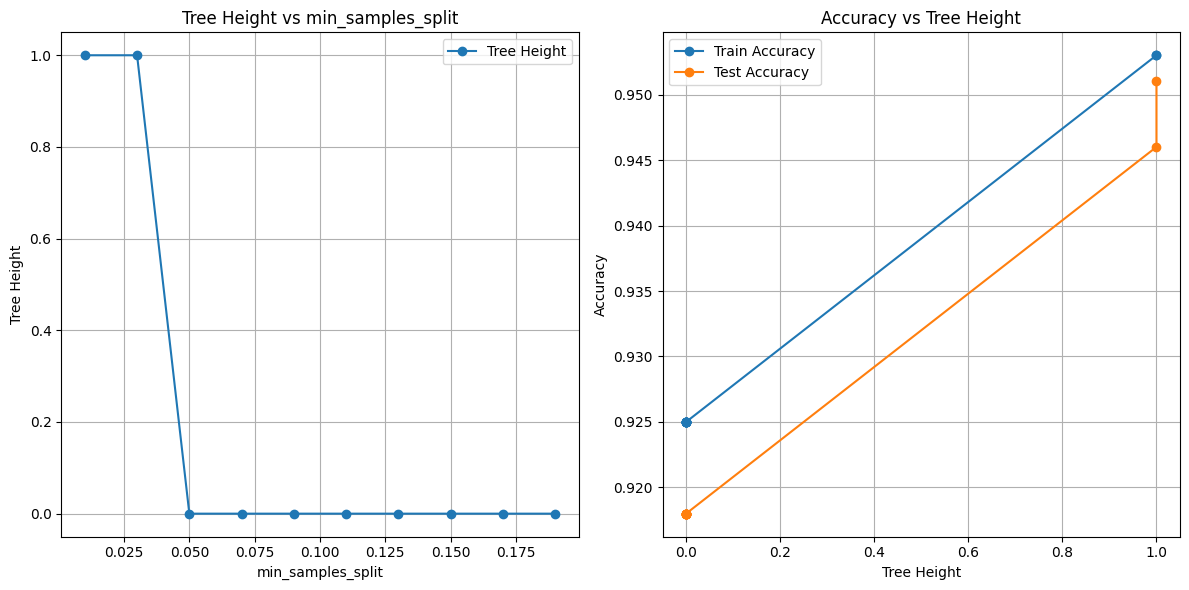

In [83]:
values = np.arange(0.01, 0.2, 0.02)
tree_heights = []
train_scores = []
test_scores = []

for min_impurity_decrease in values:
    tree1 = tree(X_train, y_train, {'min_usefull': min_impurity_decrease})
    # tree1.fit(X_train, y_train)
    
    tree_heights.append(calculate_tree_depth(tree1))
    # X_test.apply(someNode.predict, axis=1)
    train_scores.append(accuracy_score(y_train, X_train.apply(tree1.predict, axis=1)))
    test_scores.append(accuracy_score(y_test, X_test.apply(tree1.predict, axis=1)))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(values, tree_heights, marker='o', label='Tree Height')
plt.xlabel('min_samples_split')
plt.ylabel('Tree Height')
plt.title('Tree Height vs min_samples_split')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(tree_heights, train_scores, marker='o', label='Train Accuracy')
plt.plot(tree_heights, test_scores, marker='o', label='Test Accuracy')
plt.xlabel('Tree Height')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Tree Height')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

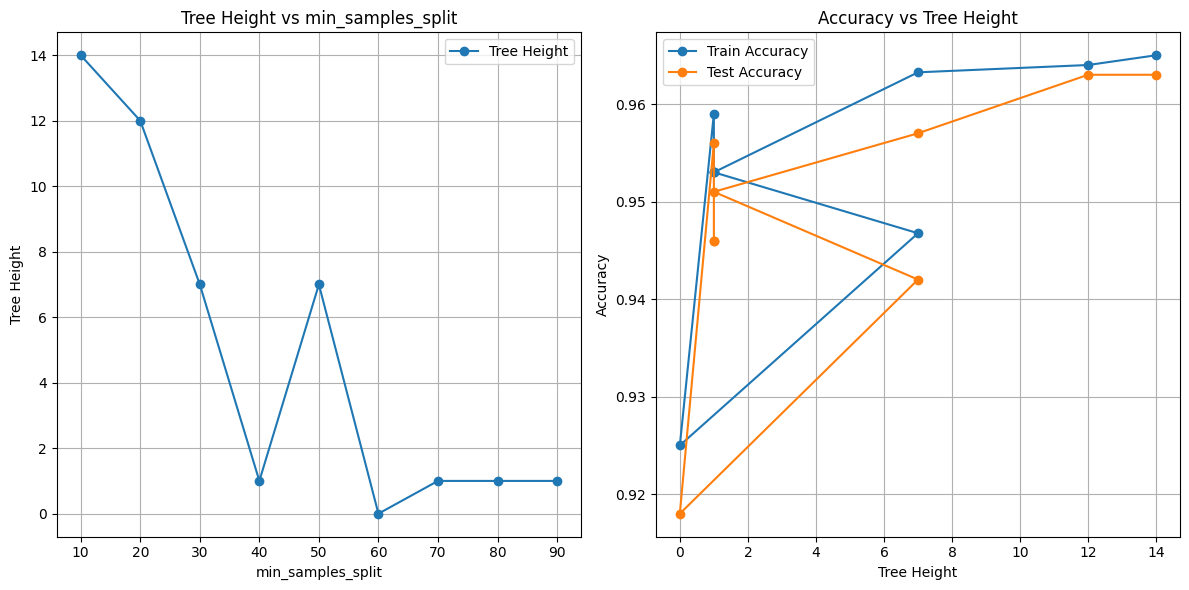

In [76]:
min_samples_leaf_values = np.arange(10, 100, 10)
tree_heights = []
train_scores = []
test_scores = []

for min_impurity_decrease in min_samples_leaf_values:
    tree1 = tree(X_train, y_train, {'min_samples_leaf': min_impurity_decrease, 'min_usefull' : 0.0000001})
    # tree1.fit(X_train, y_train)
    
    tree_heights.append(calculate_tree_depth(tree1))
    # X_test.apply(someNode.predict, axis=1)
    train_scores.append(accuracy_score(y_train, X_train.apply(tree1.predict, axis=1)))
    test_scores.append(accuracy_score(y_test, X_test.apply(tree1.predict, axis=1)))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(min_samples_leaf_values, tree_heights, marker='o', label='Tree Height')
plt.xlabel('min_samples_split')
plt.ylabel('Tree Height')
plt.title('Tree Height vs min_samples_split')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(tree_heights, train_scores, marker='o', label='Train Accuracy')
plt.plot(tree_heights, test_scores, marker='o', label='Test Accuracy')
plt.xlabel('Tree Height')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Tree Height')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

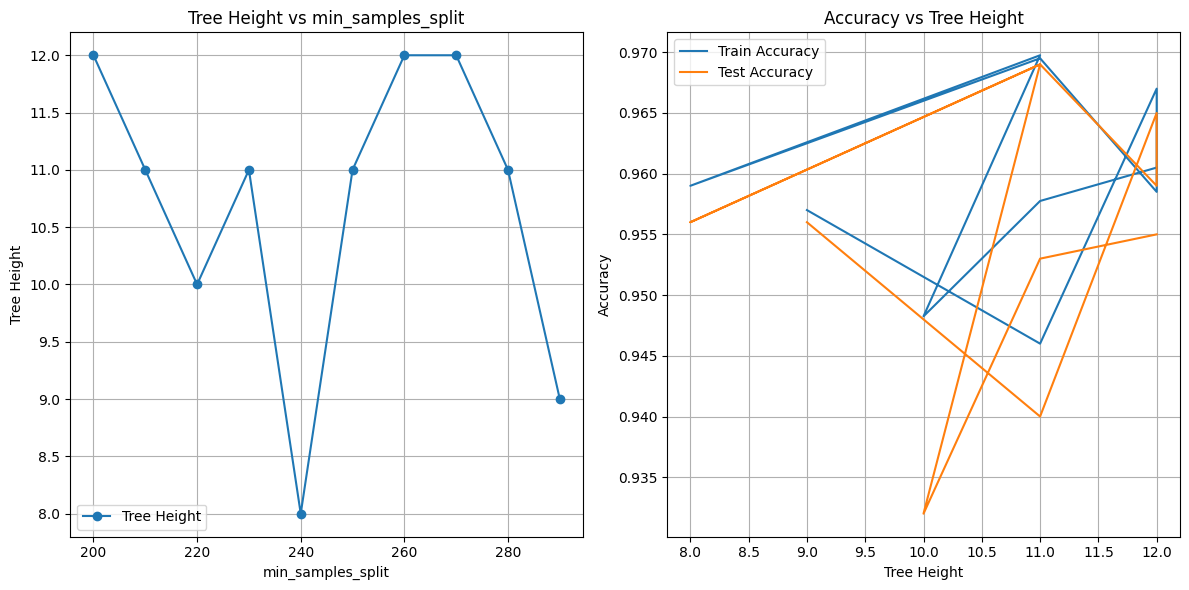

In [82]:
min_samples_split_values = np.arange(200, 300, 10)
tree_heights = []
train_scores = []
test_scores = []

for min_impurity_decrease in min_samples_split_values:
    tree1 = tree(X_train, y_train, {'min_samples_split': min_impurity_decrease})
    # tree1.fit(X_train, y_train)
    
    tree_heights.append(calculate_tree_depth(tree1))
    # X_test.apply(someNode.predict, axis=1)
    train_scores.append(accuracy_score(y_train, X_train.apply(tree1.predict, axis=1)))
    test_scores.append(accuracy_score(y_test, X_test.apply(tree1.predict, axis=1)))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(min_samples_split_values, tree_heights, marker='o', label='Tree Height')
plt.xlabel('min_samples_split')
plt.ylabel('Tree Height')
plt.title('Tree Height vs min_samples_split')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(tree_heights, train_scores, label='Train Accuracy')
plt.plot(tree_heights, test_scores, label='Test Accuracy')
plt.xlabel('Tree Height')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Tree Height')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

# случайный лес

#### бутстрап 

In [23]:
def bootstrap(X: DataFrame, y: Series):
    n_samples = len(X)
    indices = np.random.choice(n_samples, size=n_samples, replace=True)
    X_boot = X.iloc[indices]
    y_boot = y.iloc[indices]
    return X_boot, y_boot

#### урезаем признаки (на самом деле правила, для скорости)

In [24]:
# урезаем до sqrt(p) признаков (изначально признаков p)
def less_features(X: DataFrame):
    num_features = int(math.sqrt(X.shape[1]))
    selected_features = random.sample(X.columns.tolist(), num_features)
    return X[selected_features]

In [25]:
def tree_for_random_forest(X : DataFrame, y : Series, args = None):
    X1, y1 = bootstrap(X, y)
    X11 = less_features(X1)
    return tree(X11, y1, args)


#### пример random tree

Train Accuracy: 0.93025
Test Accuracy: 0.926


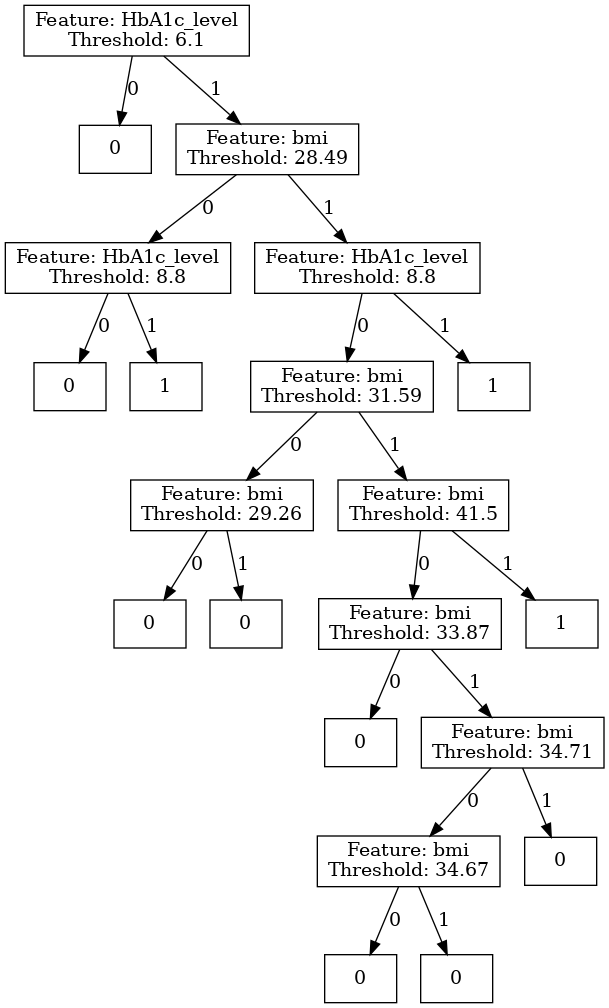

In [27]:
root_node = tree_for_random_forest(X_train, y_train, {'min_usefull': 0.005, 'max_depth' : 10})
stats(root_node)
image_path = draw_tree(root_node)
Image(filename=image_path)

In [28]:
def most_frequent_category(categories):
    unique, counts = np.unique(categories, return_counts=True)
    max_index = np.argmax(counts)
    return unique[max_index]

class RandomForest:
    def __init__(self):
        self.trees = []

    def fit(self, X, y, trees_cnt, args=None):
        for _ in range(trees_cnt):
            tree = tree_for_random_forest(X, y, args)
            # проверка что дерево проверяет хотябы 1 признак
            if isinstance(tree, EndNode):
                continue
            self.trees.append(tree)

    def predict(self, X):
        predictions = []
        for tree in self.trees:
            predictions.append(tree.predict(X))
        # возвращает самую частую категорию из предсказанных
        return most_frequent_category(predictions)

In [29]:
def stats_for_RF(rf: RandomForest):
    y_train_pred = X_train.apply(rf.predict, axis=1)
    y_test_pred = X_test.apply(rf.predict, axis=1)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f"Train Accuracy: {train_accuracy}")
    print(f"Test Accuracy: {test_accuracy}")
    # return train_accuracy, test_accuracy

In [31]:
forest = RandomForest()
forest.fit(X_train, y_train, 100, {'min_usefull': 0.06, 'max_depth' : 10})
stats_for_RF(forest)

Train Accuracy: 0.959
Test Accuracy: 0.956


In [202]:
just_tree = tree1(X_train, y_train, {'min_usefull': 0.009, 'max_depth' : 10})
stats(just_tree)

Train Accuracy: 0.9665
Test Accuracy: 0.964
